### Load Data & Preprocessing

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection, metrics, neural_network, preprocessing

path_airlines = "./datasets/airlines.csv"
path_airport = "./datasets/airports.csv"
path_flights = "./datasets/flights.csv"

SAMPLE_SIZE = 50000
df_airlines = pd.read_csv(path_airlines, low_memory=False)
df_airport = pd.read_csv(path_airport, low_memory=False)
df_flights = pd.read_csv(path_flights, low_memory=False)
df_flights = df_flights.sample(10*SAMPLE_SIZE).reset_index(drop=True)

Given the information before the flight, we want to predict (1) whether it is delayed at arrival (>15min) (2) how long it is delayed. 

We consider three sets of features, `delay_details` include the delay information, `columns_categorical` is categorical information of flights, `columns_numerical` is numerical definition of flights.

In [2]:
delay_details = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
columns_categorical = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
columns_numerical = ['SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ARRIVAL_DELAY']

Some preprocessing

In [3]:
# only January data. First 100000 lines should be january.
# df_flights = df_flights[df_flights['MONTH']==1]

# fill missing delay details with 0
df_flights[delay_details] = df_flights[delay_details].fillna(0)
# discard those columns with >10% missing values
missing_columns = df_flights.loc[:, df_flights.isna().mean() >= 0.1].columns
df_flights = df_flights.drop(missing_columns, axis=1)
# discard nan rows
df_flights.dropna(inplace=True)

# discard cancelled or diverted flights.
df_flights = df_flights[df_flights['CANCELLED'] != 1]
df_flights = df_flights[df_flights['DIVERTED'] != 1]

# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# For those airline origin/dest airport not in IATA code, we replace them with 'OTHERS'
df_flights.loc[~df_flights['AIRLINE'].isin(df_airlines['IATA_CODE'].values),'AIRLINE']='OTHERS'
df_flights.loc[~df_flights['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'].values),'ORIGIN_AIRPORT']='OTHERS'
df_flights.loc[~df_flights['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE'].values),'DESTINATION_AIRPORT']='OTHERS'

Since the time is encoded in HHMM format, we transform it into minutes, ranging from 0 to 2399

In [4]:
# transform HHMM into minutes.
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(mintues)

Since most airports have small percentages of flights, we only consider top 20 airports in terms of flights' origin and destination. We realize 19 out of 20 airport appears both in frequent_origin and frequent airport. 

In [5]:
frequent_origin = df_flights['ORIGIN_AIRPORT'].value_counts()[:20].index
frequent_dest = df_flights['DESTINATION_AIRPORT'].value_counts()[:20].index
print(frequent_origin)
print(frequent_dest)
df_flights = df_flights[df_flights['ORIGIN_AIRPORT'].isin(frequent_origin)&df_flights['DESTINATION_AIRPORT'].isin(frequent_dest)]
df_flights.shape # CANCELLATION_REASON column is removed

Index(['OTHERS', 'ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'SFO', 'IAH', 'PHX', 'LAS',
       'SEA', 'MSP', 'MCO', 'DTW', 'BOS', 'EWR', 'CLT', 'SLC', 'LGA', 'JFK'],
      dtype='object')
Index(['OTHERS', 'ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'SFO', 'PHX', 'IAH', 'LAS',
       'MSP', 'SEA', 'MCO', 'DTW', 'BOS', 'CLT', 'EWR', 'SLC', 'LGA', 'JFK'],
      dtype='object')


(144730, 30)

Since we are considering classification, we add an additional column `IS_DELAY`.

In [6]:
df_flights['IS_DELAY'] = (df_flights['ARRIVAL_DELAY'] > 15).astype(int)

## Classification

We use some flight information to predict the flight arrival delay. In othner words, we use `columns_categorical` and `columns_numerical` to predict if 'ARRIVAL_DELAY' > 15. 

We do not use `delay_detals` here, beacuse these data are collected after delay, and is useless in predicting the arrival delay in prior.

We consider linear models, ensemble models and mlp models. We analyze the effect of each feature to the outcome.

/tmp/ipykernel_20574/3358479694.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_flights_cal_keep.corr())


(50000, 78)

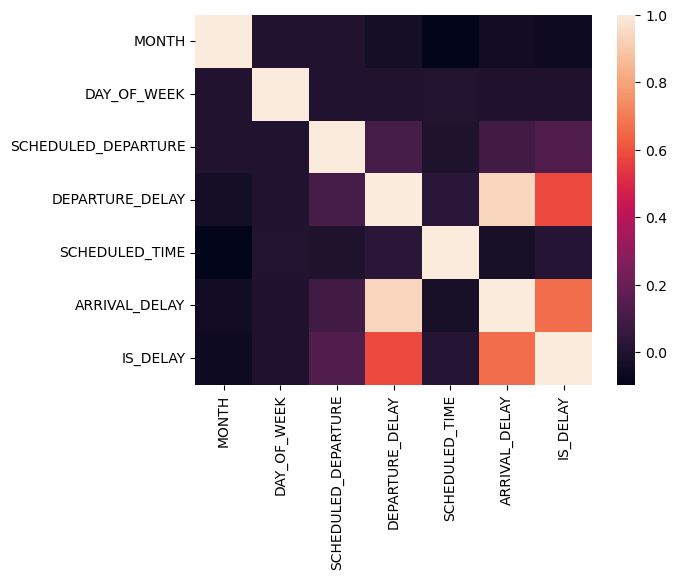

In [7]:
# only consider delayed variable
df_flights_cal = df_flights.sample(SAMPLE_SIZE).reset_index(drop=True)


# Keeping those item (see eda.ipynb for reason)
df_flights_cal_keep = df_flights_cal[columns_categorical + columns_numerical + ['IS_DELAY']].copy()

sns.heatmap(df_flights_cal_keep.corr())

# convert categorical to onehot
df_flights_cal_dummies = pd.get_dummies(df_flights_cal_keep[columns_categorical].astype(str))
df_flights_cal_keep = df_flights_cal_keep.drop(columns_categorical, axis=1)
df_flights_cal_keep=pd.concat([df_flights_cal_keep,df_flights_cal_dummies],axis=1)
df_flights_cal_keep.shape

In [8]:
df_flights_cal_keep['IS_DELAY'].value_counts()

0    41115
1     8885
Name: IS_DELAY, dtype: int64

The dataset is unbalanced. We create and balance the training dataset in the following. We keep the test dataset untouched, since we wouldn't have access to the target variable to perform resampling. 
Also, we use the minmax scaler, one hot item will not be changed by this scaler.

We write a `evaluate_classification` to include
- cross validation
- StratifiedKFold to ensure the same distribution in train and test dataset.
- Classification Report and precision-recall curve on each fold.

In [9]:
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

X_imbalanced = df_flights_cal_keep.drop(['ARRIVAL_DELAY', 'IS_DELAY'],axis=1)
X_imbalanced_columns = X_imbalanced.columns
X_imbalanced = MinMaxScaler().fit_transform(X_imbalanced)
y_imbalanced = df_flights_cal_keep['IS_DELAY'].to_numpy()

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


def evaluate_classification(classification, ax=None):
    # ensure same distribution in train and test dataset
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    if ax is None:
        fig, ax = plt.subplots()
    name = str(classification)
    displays = []
    models = []
    for i, (train_ix, test_ix) in enumerate(kfold.split(X_imbalanced, y_imbalanced)):
        X_train_imbalanced, X_test = X_imbalanced[train_ix], X_imbalanced[test_ix]
        y_train_imbalanced, y_test = y_imbalanced[train_ix], y_imbalanced[test_ix]
        # upsample minority classes
        X_train_oversampled, y_train_oversampled = resample(X_train_imbalanced[y_train_imbalanced == 1], y_train_imbalanced[y_train_imbalanced == 1], replace=True, n_samples=X_train_imbalanced[y_train_imbalanced == 0].shape[0],random_state=0)
        X_train = np.vstack((X_train_imbalanced[y_train_imbalanced == 0].copy(), X_train_oversampled))
        y_train = np.hstack((y_train_imbalanced[y_train_imbalanced == 0].copy(), y_train_oversampled))
        # to dataframe
        X_train = pd.DataFrame(X_train, columns=X_imbalanced_columns)
        X_test = pd.DataFrame(X_test, columns=X_imbalanced_columns)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        
        model = classification.fit(X_train, y_train)
        # print precision recall curve
        display = metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name+f" Fold {i+1}", ax=ax)
        displays.append(display)
        models.append(model)
        print("Classification Report" + f" Fold {i+1}\n")
        print(metrics.classification_report(y_test, classification.predict(X_test), target_names=["NOT DELAYED", "DELAYED"]))
    return models, displays



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.94      0.94      8223
     DELAYED       0.72      0.78      0.75      1777

    accuracy                           0.91     10000
   macro avg       0.84      0.86      0.85     10000
weighted avg       0.91      0.91      0.91     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.94      0.94      8223
     DELAYED       0.73      0.78      0.76      1777

    accuracy                           0.91     10000
   macro avg       0.84      0.86      0.85     10000
weighted avg       0.91      0.91      0.91     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.93      0.94      8223
     DELAYED       0.72      0.79      0.75      1777

    accuracy                           0.91     10000
   macro avg       0.84      0.86      0.85     10000
weighted avg       0.91      0.91      0.91     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report Fold 4

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.94      0.95      8223
     DELAYED       0.74      0.78      0.76      1777

    accuracy                           0.91     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.91      0.91      0.91     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report Fold 5

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.94      0.95      8223
     DELAYED       0.74      0.79      0.76      1777

    accuracy                           0.91     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.92      0.91      0.91     10000



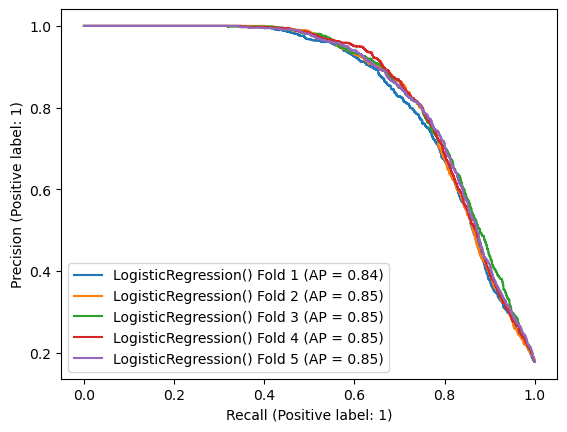

In [10]:
from sklearn.linear_model import LogisticRegression
models_logit, displays_logit = evaluate_classification(LogisticRegression())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.93      0.93      0.93      8223
     DELAYED       0.68      0.68      0.68      1777

    accuracy                           0.89     10000
   macro avg       0.80      0.81      0.81     10000
weighted avg       0.89      0.89      0.89     10000

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.93      0.93      0.93      8223
     DELAYED       0.67      0.68      0.67      1777

    accuracy                           0.88     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.88      0.88      0.88     10000

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.93      0.93      8223
     DELAYED       0.68      0.71      0.69      1777

    accuracy                           0.89     10000
   macro avg       0.81      0.82     

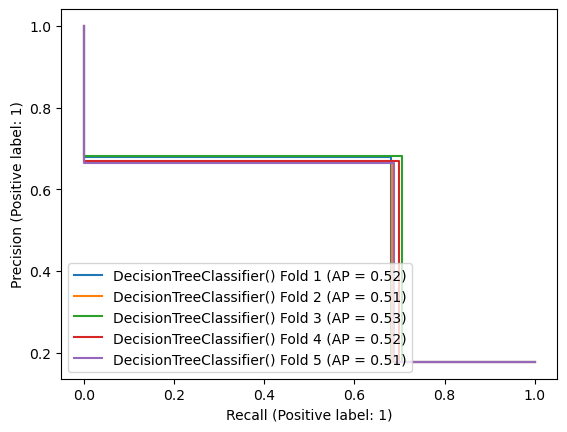

In [11]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
_, displays_dt = evaluate_classification(DecisionTreeClassifier())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.97      0.95      8223
     DELAYED       0.82      0.72      0.77      1777

    accuracy                           0.92     10000
   macro avg       0.88      0.84      0.86     10000
weighted avg       0.92      0.92      0.92     10000

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.96      0.95      8223
     DELAYED       0.81      0.73      0.77      1777

    accuracy                           0.92     10000
   macro avg       0.88      0.85      0.86     10000
weighted avg       0.92      0.92      0.92     10000

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.97      0.95      8223
     DELAYED       0.82      0.73      0.77      1777

    accuracy                           0.92     10000
   macro avg       0.88      0.85     

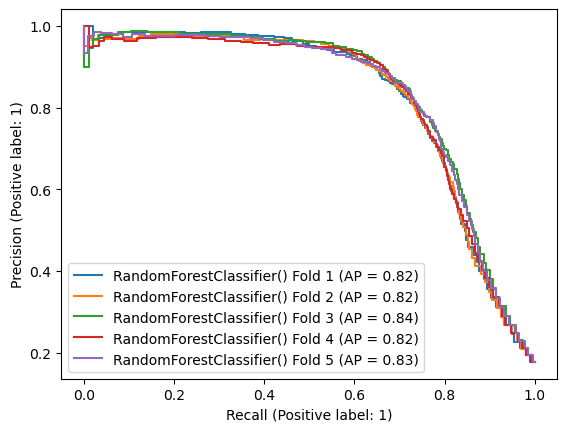

In [12]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
_, displays_rf = evaluate_classification(RandomForestClassifier())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.92      0.94      8223
     DELAYED       0.70      0.81      0.75      1777

    accuracy                           0.90     10000
   macro avg       0.83      0.86      0.84     10000
weighted avg       0.91      0.90      0.91     10000

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.92      0.94      8223
     DELAYED       0.70      0.81      0.75      1777

    accuracy                           0.90     10000
   macro avg       0.83      0.87      0.85     10000
weighted avg       0.91      0.90      0.91     10000

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.92      0.94      8223
     DELAYED       0.69      0.81      0.75      1777

    accuracy                           0.90     10000
   macro avg       0.83      0.87     

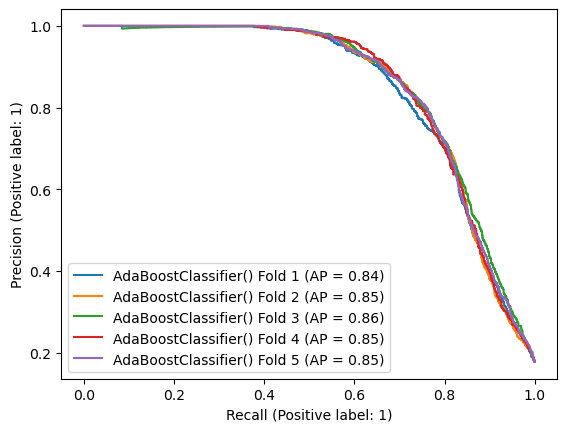

In [13]:
from sklearn.ensemble import AdaBoostClassifier
models_ada, displays_ada = evaluate_classification(AdaBoostClassifier())

/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.90      0.93      8223
     DELAYED       0.63      0.76      0.69      1777

    accuracy                           0.88     10000
   macro avg       0.79      0.83      0.81     10000
weighted avg       0.89      0.88      0.88     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.91      0.92      8223
     DELAYED       0.63      0.75      0.69      1777

    accuracy                           0.88     10000
   macro avg       0.79      0.83      0.80     10000
weighted avg       0.89      0.88      0.88     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.92      0.93      8223
     DELAYED       0.68      0.74      0.71      1777

    accuracy                           0.89     10000
   macro avg       0.81      0.83      0.82     10000
weighted avg       0.90      0.89      0.89     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 4

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.91      0.93      8223
     DELAYED       0.65      0.75      0.70      1777

    accuracy                           0.88     10000
   macro avg       0.80      0.83      0.81     10000
weighted avg       0.89      0.88      0.89     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 5

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.92      0.93      8223
     DELAYED       0.66      0.75      0.70      1777

    accuracy                           0.89     10000
   macro avg       0.80      0.83      0.82     10000
weighted avg       0.89      0.89      0.89     10000



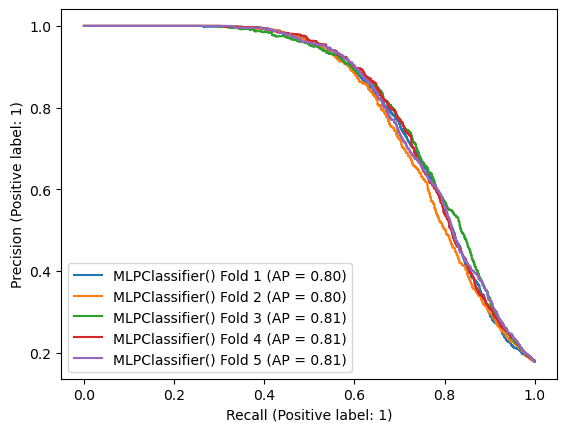

In [14]:
# MLP hidden size (100, )
from sklearn.neural_network import MLPClassifier
_, displays_mlp_1 = evaluate_classification(MLPClassifier())

We also consider 2 hidden layers.

/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.91      0.93      8223
     DELAYED       0.65      0.80      0.71      1777

    accuracy                           0.89     10000
   macro avg       0.80      0.85      0.82     10000
weighted avg       0.90      0.89      0.89     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.89      0.92      8223
     DELAYED       0.61      0.81      0.70      1777

    accuracy                           0.87     10000
   macro avg       0.78      0.85      0.81     10000
weighted avg       0.89      0.87      0.88     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.92      0.94      8223
     DELAYED       0.69      0.80      0.74      1777

    accuracy                           0.90     10000
   macro avg       0.82      0.86      0.84     10000
weighted avg       0.91      0.90      0.90     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 4

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.92      0.93      8223
     DELAYED       0.67      0.79      0.73      1777

    accuracy                           0.89     10000
   macro avg       0.81      0.85      0.83     10000
weighted avg       0.90      0.89      0.90     10000



/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report Fold 5

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.92      0.93      8223
     DELAYED       0.67      0.79      0.73      1777

    accuracy                           0.89     10000
   macro avg       0.81      0.86      0.83     10000
weighted avg       0.90      0.89      0.90     10000



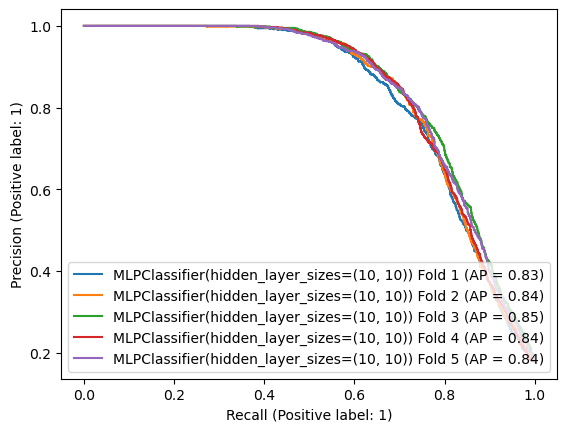

In [15]:
# MLP hidden size (10, 10)
from sklearn.neural_network import MLPClassifier
models_mlp_2, displays_mlp_2 = evaluate_classification(MLPClassifier(hidden_layer_sizes=(10,10)))

We plot the Precision-Recall curve together. Since the dataset is imbalanced, we should not use ROC curve here.

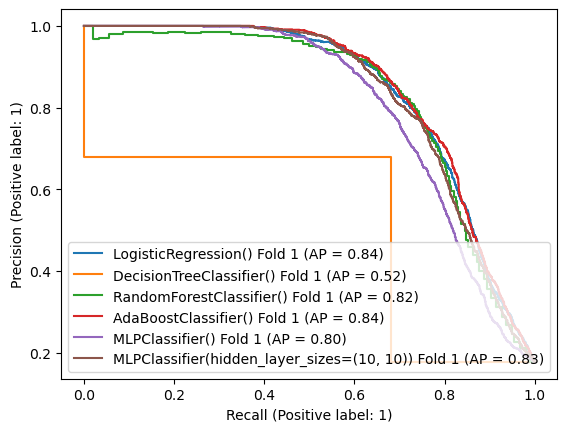

In [16]:
fig, ax = plt.subplots()
for display in [displays_logit[0], displays_dt[0], displays_rf[0], displays_ada[0], displays_mlp_1[0], displays_mlp_2[0]]:
    display.plot(ax=ax)

We find that for ensemble method, RandomForest is the best choice. For single predictor method (non-ensemble), MLP with two hidden layers and logit regression are the best. The performance of these two are similar. Since ensemble methods lack explainability inherently, we only consider the non-ensemble case.

Let us start with Logistic Regression. The coefficient larger than 0 means contribute positively to delay, smaller than 0 means otherwise. We look at the full coefficient, we find that 'DEPARTURE_DELAY' largely determines the arrival delay, which coincides with our ituition. Then, we see them separately.


In [17]:
logit = models_logit[0]
logit_feature_dict = dict(zip(logit.feature_names_in_.tolist(), logit.coef_[0].tolist()))
logit_feature_dict

{'SCHEDULED_DEPARTURE': 0.6865224581858743,
 'DEPARTURE_DELAY': 76.39552842703901,
 'SCHEDULED_TIME': -0.12932703576199397,
 'MONTH_1': 0.03021813465845203,
 'MONTH_10': -0.12081468595753912,
 'MONTH_11': -0.06881734211429923,
 'MONTH_12': 0.09096486216421085,
 'MONTH_2': 0.2585512287594646,
 'MONTH_3': -0.030357639870279965,
 'MONTH_4': -0.143014964816065,
 'MONTH_5': 0.055568652827068556,
 'MONTH_6': 0.15812912365021806,
 'MONTH_7': 0.08660632813027225,
 'MONTH_8': -0.06256922859475769,
 'MONTH_9': -0.2560699945593652,
 'DAY_OF_WEEK_1': -0.015499790571873836,
 'DAY_OF_WEEK_2': 0.0009622165199585573,
 'DAY_OF_WEEK_3': -0.10479145972123248,
 'DAY_OF_WEEK_4': 0.19243373678660525,
 'DAY_OF_WEEK_5': 0.14056341709499878,
 'DAY_OF_WEEK_6': -0.12528802896041544,
 'DAY_OF_WEEK_7': -0.08998561687018272,
 'AIRLINE_AA': -0.034786494997344326,
 'AIRLINE_AS': -0.08305881970479356,
 'AIRLINE_B6': 0.1468353710542685,
 'AIRLINE_DL': -0.3423944767152534,
 'AIRLINE_EV': -0.08796668527696079,
 'AIRLINE_

We can see that flights airline NK will be most likely to be delayed, and airline NK, WN, EV, AA, F9, OD, NQ will have positive effect (>1) of delay, it coincides with the empirical delay probability.  

[('AIRLINE_F9', 0.5892523234288094), ('AIRLINE_NK', 0.4603892278862925), ('AIRLINE_OO', 0.16551845858211942), ('AIRLINE_B6', 0.1468353710542685), ('AIRLINE_US', 0.03693621879736705), ('AIRLINE_AA', -0.034786494997344326), ('AIRLINE_MQ', -0.04770300646813511), ('AIRLINE_AS', -0.08305881970479356), ('AIRLINE_EV', -0.08796668527696079), ('AIRLINE_VX', -0.11296373404486038), ('AIRLINE_WN', -0.1950287294510073), ('AIRLINE_HA', -0.23572384106813624), ('AIRLINE_UA', -0.2609113377428713), ('AIRLINE_DL', -0.3423944767152534)]


<Axes: ylabel='AIRLINE'>

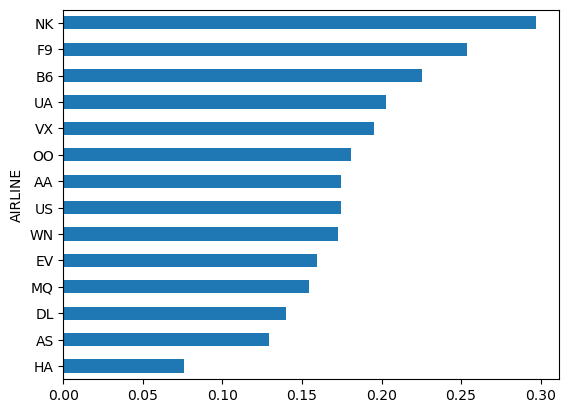

In [18]:
airline_keys = [(x, logit_feature_dict[x]) for x in logit_feature_dict.keys() if 'AIRLINE' in x]
airline_keys.sort(key=lambda x: x[1], reverse=True)
print(airline_keys)
df_flights_cal.groupby('AIRLINE')['IS_DELAY'].mean().sort_values().plot(kind='barh')

We can also observe flights in week day 7, 1 are likely to be delayed, but flight in week day 3, 4 are not likely to be delayed. These observation coincides with the empirical delay probability.

[('DAY_OF_WEEK_4', 0.19243373678660525), ('DAY_OF_WEEK_5', 0.14056341709499878), ('DAY_OF_WEEK_2', 0.0009622165199585573), ('DAY_OF_WEEK_1', -0.015499790571873836), ('DAY_OF_WEEK_7', -0.08998561687018272), ('DAY_OF_WEEK_3', -0.10479145972123248), ('DAY_OF_WEEK_6', -0.12528802896041544)]


<Axes: ylabel='DAY_OF_WEEK'>

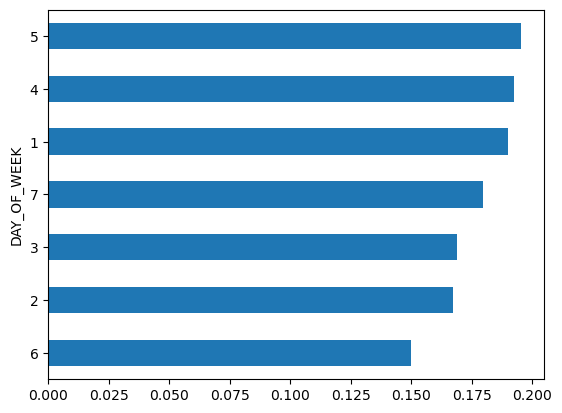

In [19]:
week_keys = [(x, logit_feature_dict[x]) for x in logit_feature_dict.keys() if 'DAY_OF_WEEK' in x]
week_keys.sort(key=lambda x: x[1], reverse=True)
print(week_keys)
df_flights.groupby('DAY_OF_WEEK')['IS_DELAY'].mean().sort_values().plot(kind='barh')

Then, we considet the airport. We find JFK contribute positively to the delay, which coincides with our intuition since JFK is a busy airport.

[('ORIGIN_AIRPORT_BOS', 0.17715727594403646), ('ORIGIN_AIRPORT_MSP', 0.15130568841796782), ('ORIGIN_AIRPORT_LGA', 0.1485387364323979), ('ORIGIN_AIRPORT_ORD', 0.1362504529156515), ('ORIGIN_AIRPORT_JFK', 0.11597691238855934), ('ORIGIN_AIRPORT_DTW', 0.10012068611395193), ('ORIGIN_AIRPORT_DEN', 0.07727358026911563), ('ORIGIN_AIRPORT_CLT', 0.0695848224016095), ('ORIGIN_AIRPORT_LAX', 0.007351713406612326), ('ORIGIN_AIRPORT_PHX', 0.003868238226008385), ('ORIGIN_AIRPORT_MCO', -0.004962343667619709), ('ORIGIN_AIRPORT_IAH', -0.006467580938187479), ('ORIGIN_AIRPORT_EWR', -0.08488923432304468), ('ORIGIN_AIRPORT_LAS', -0.08811032026317314), ('ORIGIN_AIRPORT_SEA', -0.11852285846902105), ('ORIGIN_AIRPORT_OTHERS', -0.12081468595753912), ('ORIGIN_AIRPORT_SFO', -0.12462918195332459), ('ORIGIN_AIRPORT_DFW', -0.13691540470570665), ('ORIGIN_AIRPORT_SLC', -0.1517576078309325), ('ORIGIN_AIRPORT_ATL', -0.15196441412812525)]


<Axes: ylabel='ORIGIN_AIRPORT'>

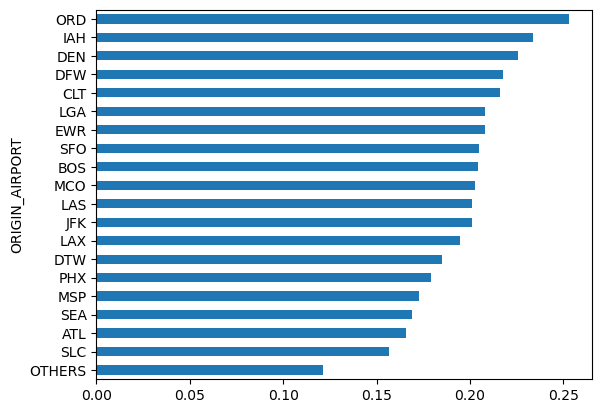

In [20]:
origin_keys = [(x, logit_feature_dict[x]) for x in logit_feature_dict.keys() if 'ORIGIN' in x]
origin_keys.sort(key=lambda x: x[1], reverse=True)
print(origin_keys)
df_flights.groupby('ORIGIN_AIRPORT')['IS_DELAY'].mean().sort_values().plot(kind='barh')

[('ORIGIN_AIRPORT_BOS', 0.17715727594403646), ('ORIGIN_AIRPORT_MSP', 0.15130568841796782), ('ORIGIN_AIRPORT_LGA', 0.1485387364323979), ('ORIGIN_AIRPORT_ORD', 0.1362504529156515), ('ORIGIN_AIRPORT_JFK', 0.11597691238855934), ('ORIGIN_AIRPORT_DTW', 0.10012068611395193), ('ORIGIN_AIRPORT_DEN', 0.07727358026911563), ('ORIGIN_AIRPORT_CLT', 0.0695848224016095), ('ORIGIN_AIRPORT_LAX', 0.007351713406612326), ('ORIGIN_AIRPORT_PHX', 0.003868238226008385), ('ORIGIN_AIRPORT_MCO', -0.004962343667619709), ('ORIGIN_AIRPORT_IAH', -0.006467580938187479), ('ORIGIN_AIRPORT_EWR', -0.08488923432304468), ('ORIGIN_AIRPORT_LAS', -0.08811032026317314), ('ORIGIN_AIRPORT_SEA', -0.11852285846902105), ('ORIGIN_AIRPORT_OTHERS', -0.12081468595753912), ('ORIGIN_AIRPORT_SFO', -0.12462918195332459), ('ORIGIN_AIRPORT_DFW', -0.13691540470570665), ('ORIGIN_AIRPORT_SLC', -0.1517576078309325), ('ORIGIN_AIRPORT_ATL', -0.15196441412812525)]


<Axes: ylabel='DESTINATION_AIRPORT'>

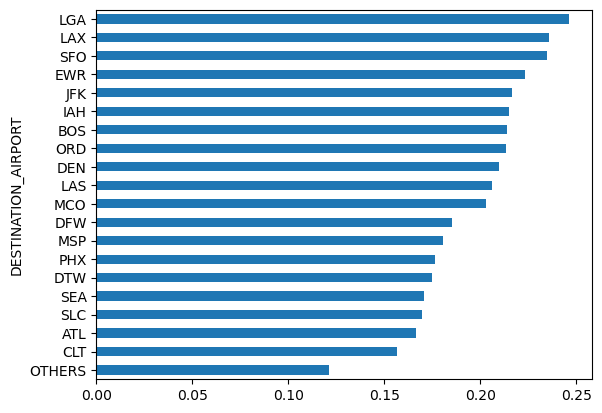

In [21]:
dest_keys = [(x, logit_feature_dict[x]) for x in logit_feature_dict.keys() if 'ORIGIN' in x]
dest_keys.sort(key=lambda x: x[1], reverse=True)
print(dest_keys)
df_flights.groupby('DESTINATION_AIRPORT')['IS_DELAY'].mean().sort_values().plot(kind='barh')

Next, we analyze MLP. The MLP can be written as $Y=a^\top \sigma(W_2\sigma(XW_1))$. 

In [22]:
mlp = models_mlp_2[0]
W_1, W_2, a = mlp.coefs_[0], mlp.coefs_[1], mlp.coefs_[2]

Let us consider $f(x)=a^\top\sigma(W_2^\top\sigma(W_1^\top x))$, by the matrix gradient algorithm, we have
$$
\nabla_x f(x) = W_1((W_2(a \odot \sigma' (W_2^\top\sigma(W_1^\top x))))\odot \sigma'(W_1^\top x))
$$
using the trace equality, 
$tr(A^\top(B\odot C))=tr((A\odot B)^\top C)$

In [23]:
def mlp_gradient(x: np.ndarray):
    l1 = np.dot(W_1.T, x)
    dl1 = np.greater(l1, 0).astype(float)
    l2 = np.dot(W_2, np.maximum(l1, 0))
    dl2 = np.greater(l2, 0).astype(float)
    return np.dot(W_1, np.dot(W_2, a*dl2) * dl1)

We consider $\nabla_x f(x)|_{x={1,1,\cdots,1}}$, which measures the importance of each feature.

In [24]:
ones = np.ones((W_1.shape[0],1))
g_ones = mlp_gradient(ones)
mlp_feature_dict = dict(zip(mlp.feature_names_in_.tolist(), g_ones.tolist()))

NK still contributes positively most to the delay probability

[('AIRLINE_F9', [1.1089363132335417]), ('AIRLINE_OO', [0.9877794120803323]), ('AIRLINE_MQ', [0.09586274587675492]), ('AIRLINE_VX', [0.07007798192014092]), ('AIRLINE_NK', [-0.07027978110658728]), ('AIRLINE_US', [-0.24201051606418966]), ('AIRLINE_B6', [-0.34136616232608386]), ('AIRLINE_AS', [-0.3459394105193321]), ('AIRLINE_WN', [-0.5331362417491189]), ('AIRLINE_UA', [-1.0241557630714533]), ('AIRLINE_AA', [-1.0268364071222063]), ('AIRLINE_DL', [-1.275380025315346]), ('AIRLINE_HA', [-1.3616322233313625]), ('AIRLINE_EV', [-1.7870331870641454])]


<Axes: ylabel='AIRLINE'>

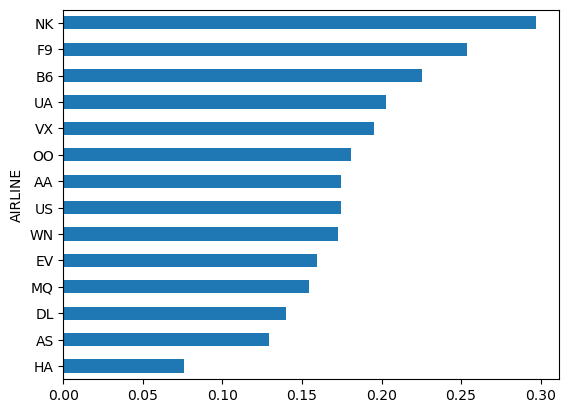

In [25]:
airline_keys = [(x, mlp_feature_dict[x]) for x in mlp_feature_dict.keys() if 'AIRLINE' in x]
airline_keys.sort(key=lambda x: x[1], reverse=True)
print(airline_keys)
df_flights_cal.groupby('AIRLINE')['IS_DELAY'].mean().sort_values().plot(kind='barh')

JFK, among all the origin and destination airports, stil contributes positively the most to the delay probability.

[('ORIGIN_AIRPORT_DFW', [0.9734748566010822]), ('ORIGIN_AIRPORT_MSP', [0.6727675757461882]), ('ORIGIN_AIRPORT_DEN', [0.6097412293364725]), ('ORIGIN_AIRPORT_SFO', [0.3941946551887163]), ('ORIGIN_AIRPORT_ATL', [0.3775323918692195]), ('ORIGIN_AIRPORT_BOS', [0.05103013706747128]), ('ORIGIN_AIRPORT_MCO', [0.009962683180608]), ('ORIGIN_AIRPORT_CLT', [-0.04468803993070658]), ('ORIGIN_AIRPORT_SLC', [-0.09610568381516171]), ('ORIGIN_AIRPORT_SEA', [-0.11641267909612285]), ('ORIGIN_AIRPORT_DTW', [-0.1360458000246365]), ('ORIGIN_AIRPORT_IAH', [-0.1439073040783878]), ('ORIGIN_AIRPORT_PHX', [-0.18525478365900838]), ('ORIGIN_AIRPORT_OTHERS', [-0.4624602523410113]), ('ORIGIN_AIRPORT_LAX', [-0.5657109523303447]), ('ORIGIN_AIRPORT_LAS', [-0.5993310881103694]), ('ORIGIN_AIRPORT_ORD', [-0.6009135159268124]), ('ORIGIN_AIRPORT_EWR', [-1.1060379914389682]), ('ORIGIN_AIRPORT_LGA', [-1.7077937449481924]), ('ORIGIN_AIRPORT_JFK', [-3.7270507986589854])]


<Axes: ylabel='ORIGIN_AIRPORT'>

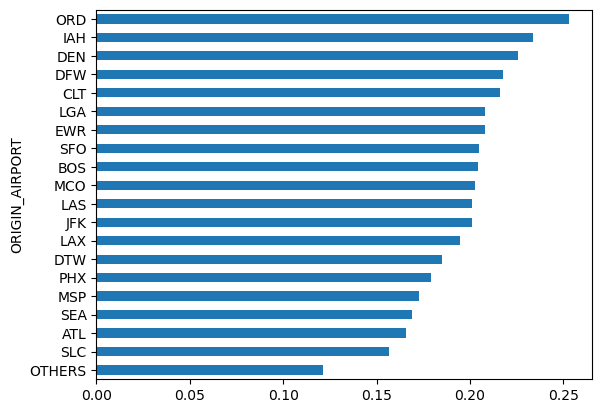

In [26]:
origin_keys = [(x, mlp_feature_dict[x]) for x in mlp_feature_dict.keys() if 'ORIGIN' in x]
origin_keys.sort(key=lambda x: x[1], reverse=True)
print(origin_keys)
df_flights.groupby('ORIGIN_AIRPORT')['IS_DELAY'].mean().sort_values().plot(kind='barh')

[('ORIGIN_AIRPORT_DFW', [0.9734748566010822]), ('ORIGIN_AIRPORT_MSP', [0.6727675757461882]), ('ORIGIN_AIRPORT_DEN', [0.6097412293364725]), ('ORIGIN_AIRPORT_SFO', [0.3941946551887163]), ('ORIGIN_AIRPORT_ATL', [0.3775323918692195]), ('ORIGIN_AIRPORT_BOS', [0.05103013706747128]), ('ORIGIN_AIRPORT_MCO', [0.009962683180608]), ('ORIGIN_AIRPORT_CLT', [-0.04468803993070658]), ('ORIGIN_AIRPORT_SLC', [-0.09610568381516171]), ('ORIGIN_AIRPORT_SEA', [-0.11641267909612285]), ('ORIGIN_AIRPORT_DTW', [-0.1360458000246365]), ('ORIGIN_AIRPORT_IAH', [-0.1439073040783878]), ('ORIGIN_AIRPORT_PHX', [-0.18525478365900838]), ('ORIGIN_AIRPORT_OTHERS', [-0.4624602523410113]), ('ORIGIN_AIRPORT_LAX', [-0.5657109523303447]), ('ORIGIN_AIRPORT_LAS', [-0.5993310881103694]), ('ORIGIN_AIRPORT_ORD', [-0.6009135159268124]), ('ORIGIN_AIRPORT_EWR', [-1.1060379914389682]), ('ORIGIN_AIRPORT_LGA', [-1.7077937449481924]), ('ORIGIN_AIRPORT_JFK', [-3.7270507986589854])]


<Axes: ylabel='DESTINATION_AIRPORT'>

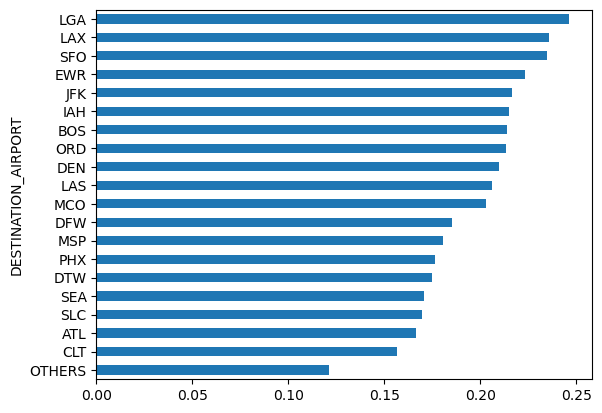

In [27]:
dest_keys = [(x, mlp_feature_dict[x]) for x in mlp_feature_dict.keys() if 'ORIGIN' in x]
dest_keys.sort(key=lambda x: x[1], reverse=True)
print(dest_keys)
df_flights.groupby('DESTINATION_AIRPORT')['IS_DELAY'].mean().sort_values().plot(kind='barh')

## Regression
Can we predict the arrival delay time? We use some flight information to predict the flight arrival delay. In othner words, we use `columns_categorical` and `columns_numerical` to predict to predict the value of flight delay. 

In [28]:
# Since the extreme values will largely impact the performance, we only keep those delayed less than 2 hours. 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
df_flights_reg = df_flights.sample(SAMPLE_SIZE).reset_index(drop=True)
# Keeping those item (see eda.ipynb for reason)
df_flights_reg_keep = df_flights_reg[columns_categorical + columns_numerical].copy()

# # only consider delayed flights at departure
df_flights_reg_keep = df_flights_reg_keep[(df_flights_reg_keep['DEPARTURE_DELAY']>=15)].reset_index(drop=True).copy()


df_flights_reg_dummies = pd.get_dummies(df_flights_reg_keep[columns_categorical].astype(str))
df_flights_reg_keep = df_flights_reg_keep.drop(columns_categorical, axis=1)
df_flights_reg_keep=pd.concat([df_flights_reg_keep,df_flights_reg_dummies],axis=1)


# we do not consider scaling nor upsampling here for regression. 
X_reg = df_flights_reg_keep.drop(['ARRIVAL_DELAY'],axis=1)
X_reg = pd.DataFrame(MinMaxScaler().fit_transform(X_reg), columns=X_reg.columns)
y_reg = df_flights_reg_keep['ARRIVAL_DELAY'].ravel()

def evaluate_regression(regression):
    name = str(regression)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = cross_val_score(regression, X_reg, y_reg, cv=cv)
    print(f"{name} Avergaed R^2 is {scores.mean()} with a standard deviation of {scores.std()}")


In [29]:
df_flights_reg_keep.shape

(9245, 77)

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
evaluate_regression(LinearRegression())
evaluate_regression(Ridge(alpha=0.01))
evaluate_regression(Lasso(alpha=0.01))
evaluate_regression(ElasticNet(alpha=0.001))

LinearRegression() Avergaed R^2 is 0.9439592865018497 with a standard deviation of 0.0031924907283408513
Ridge(alpha=0.01) Avergaed R^2 is 0.9439690690336298 with a standard deviation of 0.003181621355460104
Lasso(alpha=0.01) Avergaed R^2 is 0.9440627378542386 with a standard deviation of 0.0031560909862008305
ElasticNet(alpha=0.001) Avergaed R^2 is 0.928261189067924 with a standard deviation of 0.0027506985452934165


In [31]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
evaluate_regression(RandomForestRegressor())
evaluate_regression(AdaBoostRegressor(learning_rate=0.1))

RandomForestRegressor() Avergaed R^2 is 0.9382617521322117 with a standard deviation of 0.004012380125761225
AdaBoostRegressor(learning_rate=0.1) Avergaed R^2 is 0.918669358925893 with a standard deviation of 0.007134360369359116


In [32]:
from sklearn.neural_network import MLPRegressor
evaluate_regression(MLPRegressor(hidden_layer_sizes=(100,), solver='sgd'))

/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(solver='sgd') Avergaed R^2 is 0.9257445567765646 with a standard deviation of 0.00477723009806627


/home/yhangchen/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
from sklearn.neural_network import MLPRegressor
evaluate_regression(MLPRegressor(hidden_layer_sizes=(10, 10), solver='sgd'))

MLPRegressor(hidden_layer_sizes=(10, 10), solver='sgd') Avergaed R^2 is 0.8045436798961045 with a standard deviation of 0.2555772692274361


Hence, a simple Ridge will suffice here. We want our feature magnitude to be small. We also analyze the coefficient. It matches the empirical averge delay time properly. We although R^2 of linear regression is also around 0.9, the coefficient in linear regression is too large. 

[('AIRLINE_F9', 5.211956813012314), ('AIRLINE_NK', 4.072297070256379), ('AIRLINE_HA', 2.9564357889185438), ('AIRLINE_AS', 0.988872843623849), ('AIRLINE_B6', 0.6761251760293356), ('AIRLINE_AA', -0.12016409385389495), ('AIRLINE_EV', -0.34435021844785113), ('AIRLINE_VX', -0.8467428086264989), ('AIRLINE_US', -1.0035502859469456), ('AIRLINE_OO', -1.0181843324996889), ('AIRLINE_DL', -1.6342209129793408), ('AIRLINE_WN', -2.609355223874348), ('AIRLINE_MQ', -2.682012330755042), ('AIRLINE_UA', -3.647107487782564)]


<Axes: ylabel='AIRLINE'>

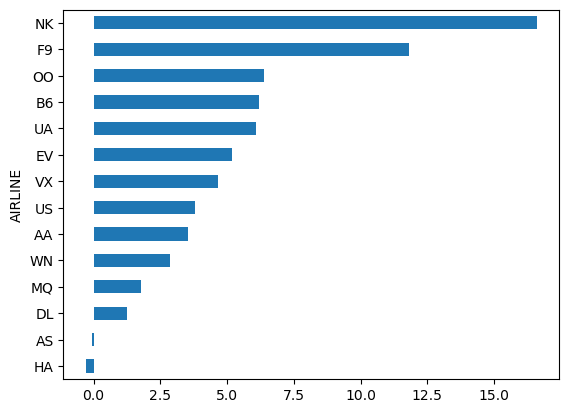

In [34]:
from sklearn.model_selection import train_test_split
X_train_reg, _, y_train_reg, _ = train_test_split(X_reg,  y_reg)
linear = Ridge(alpha=0.01).fit(X_train_reg,  y_train_reg)
linear_feature_dict = dict(zip(linear.feature_names_in_.tolist(), linear.coef_.tolist()))
airline_keys = [(x, linear_feature_dict[x]) for x in linear_feature_dict.keys() if 'AIRLINE' in x]
airline_keys.sort(key=lambda x: x[1], reverse=True)
print(airline_keys)
df_flights_reg.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values().plot(kind='barh')

[('ORIGIN_AIRPORT_CLT', 3.7332947066607423), ('ORIGIN_AIRPORT_BOS', 3.5202091200338774), ('ORIGIN_AIRPORT_DEN', 2.1735308525387524), ('ORIGIN_AIRPORT_MCO', 1.8690469728157533), ('ORIGIN_AIRPORT_SFO', 1.1351077383772539), ('ORIGIN_AIRPORT_DTW', 0.36651530137672866), ('ORIGIN_AIRPORT_LAX', 0.20276208329511253), ('ORIGIN_AIRPORT_SEA', -0.15972211085020527), ('ORIGIN_AIRPORT_MSP', -0.39310422101582393), ('ORIGIN_AIRPORT_OTHERS', -0.4048391190419568), ('ORIGIN_AIRPORT_EWR', -0.5926963147553923), ('ORIGIN_AIRPORT_SLC', -0.8102295581094633), ('ORIGIN_AIRPORT_ORD', -0.8997191863062287), ('ORIGIN_AIRPORT_LAS', -0.9319959663076756), ('ORIGIN_AIRPORT_LGA', -0.9587413637405906), ('ORIGIN_AIRPORT_DFW', -1.017610073096367), ('ORIGIN_AIRPORT_JFK', -1.4887301773106696), ('ORIGIN_AIRPORT_IAH', -1.4908361052337717), ('ORIGIN_AIRPORT_ATL', -1.85793020029383), ('ORIGIN_AIRPORT_PHX', -1.994312380087147)]


<Axes: ylabel='ORIGIN_AIRPORT'>

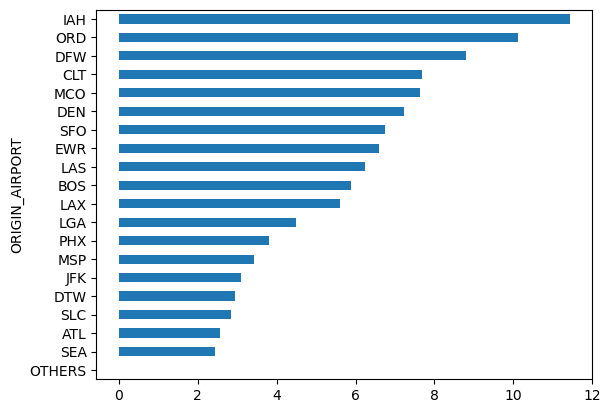

In [35]:
origin_keys = [(x, linear_feature_dict[x]) for x in linear_feature_dict.keys() if 'ORIGIN' in x]
origin_keys.sort(key=lambda x: x[1], reverse=True)
print(origin_keys)
df_flights_reg.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].mean().sort_values().plot(kind='barh')

[('DESTINATION_AIRPORT_LAX', 2.6930801391352532), ('DESTINATION_AIRPORT_ORD', 2.0593582181209653), ('DESTINATION_AIRPORT_SFO', 1.818705179106681), ('DESTINATION_AIRPORT_MCO', 1.6459890192319144), ('DESTINATION_AIRPORT_SEA', 1.499855269400106), ('DESTINATION_AIRPORT_LGA', 0.8851843522726485), ('DESTINATION_AIRPORT_IAH', 0.7533544030690111), ('DESTINATION_AIRPORT_LAS', 0.7219729646802592), ('DESTINATION_AIRPORT_CLT', 0.6819080018748412), ('DESTINATION_AIRPORT_BOS', 0.5045528071438472), ('DESTINATION_AIRPORT_DTW', -0.048825913714308854), ('DESTINATION_AIRPORT_PHX', -0.34542713612456183), ('DESTINATION_AIRPORT_OTHERS', -0.40483911905791864), ('DESTINATION_AIRPORT_EWR', -0.6611123794639413), ('DESTINATION_AIRPORT_SLC', -0.9055526266634434), ('DESTINATION_AIRPORT_JFK', -1.426717852049492), ('DESTINATION_AIRPORT_DEN', -1.9794310693561985), ('DESTINATION_AIRPORT_DFW', -2.144104475272886), ('DESTINATION_AIRPORT_ATL', -2.6111256507497207), ('DESTINATION_AIRPORT_MSP', -2.736824132045399)]


<Axes: ylabel='DESTINATION_AIRPORT'>

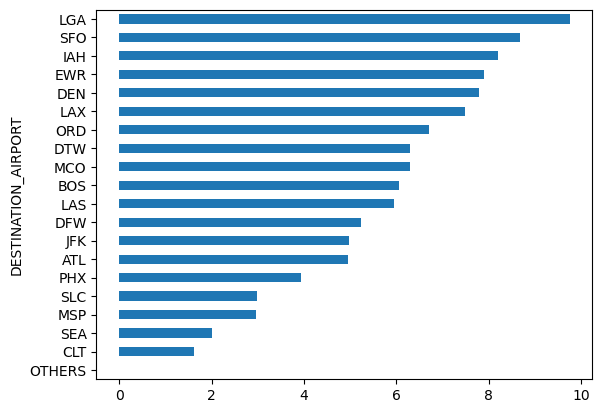

In [36]:
dest_keys = [(x, linear_feature_dict[x]) for x in linear_feature_dict.keys() if 'DEST' in x]
dest_keys.sort(key=lambda x: x[1], reverse=True)
print(dest_keys)
df_flights_reg.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].mean().sort_values().plot(kind='barh')

We notice that although flights in JFK is highly likely to be delayed, the average delay time is not large. 